# Load the data

In [ ]:
import numpy as np
import pandas as pd
import os

filename = "data.csv"
df = pd.read_csv(filename,
                 encoding="utf-8", encoding_errors="replace")
df.columns = ["text", "sentiment"]
df.head(10)

,text,sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
5,$SPY wouldn't be surprised to see a green close,positive
6,Shell's $70 Billion BG Deal Meets Shareholder ...,negative
7,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,negative
8,Kone 's net sales rose by some 14 % year-on-ye...,positive
9,The Stockmann department store will have a tot...,neutral


sentiment
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64


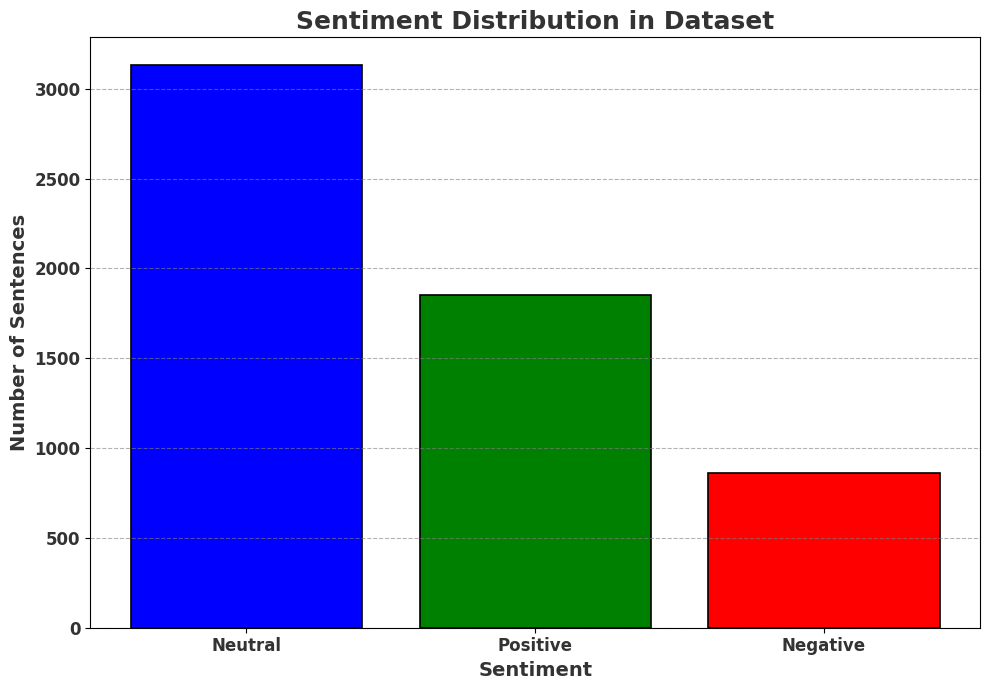

text         0
sentiment    0
dtype: int64


In [ ]:
print(df['sentiment'].value_counts())  # Controlla distribuzione etichette

import seaborn as sns
import matplotlib.pyplot as plt

# Conteggio dei sentiment
sentiment_counts = df['sentiment'].value_counts()

# Grafico della distribuzione dei sentiment
plt.figure(figsize=(10, 7))
plt.bar(
    sentiment_counts.index,
    sentiment_counts.values,
    tick_label=['Neutral', 'Positive', 'Negative'],  # Ordine delle etichette
    color=['#0000FF', '#008000', '#FF0000'],        # Colori personalizzati
    edgecolor='black',
    linewidth=1.2
)
plt.title('Sentiment Distribution in Dataset', fontsize=18, fontweight='bold', color='#333333')
plt.xlabel('Sentiment', fontsize=14, fontweight='bold', color='#333333')
plt.ylabel('Number of Sentences', fontsize=14, fontweight='bold', color='#333333')
plt.grid(axis='y', linestyle='--', alpha=0.6, color='gray')
plt.xticks(fontsize=12, fontweight='bold', color='#333333')
plt.yticks(fontsize=12, fontweight='bold', color='#333333')
plt.tight_layout()
plt.show()

# Controlla valori mancanti
missing_values = df.isnull().sum()
print(missing_values)



Distribuzione bilanciata delle etichette:
sentiment
negative    1666
neutral     1666
positive    1666
Name: count, dtype: int64


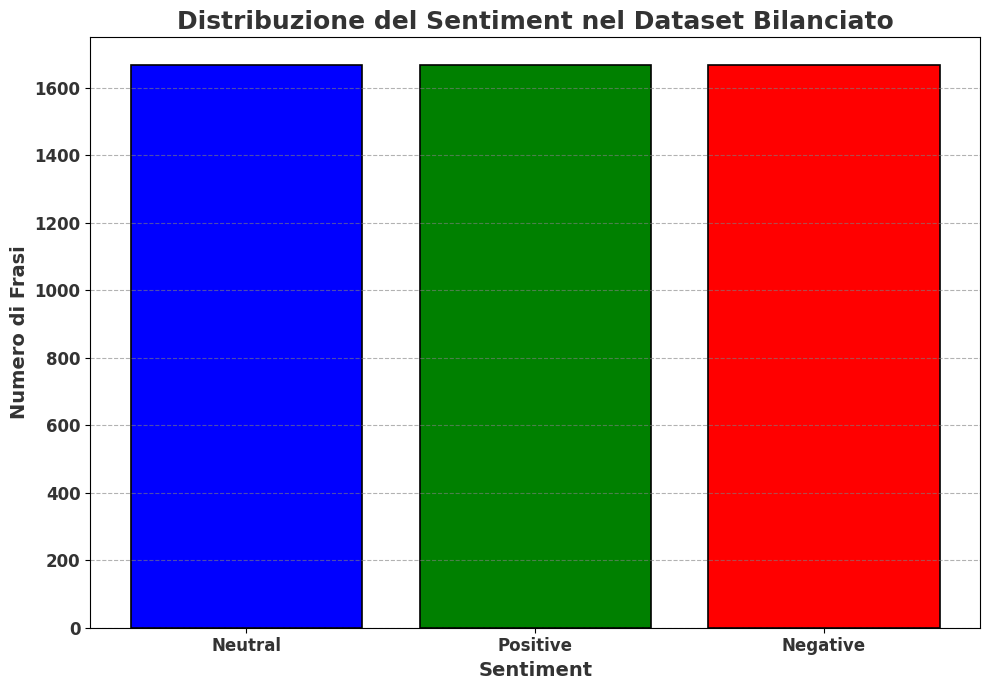

In [ ]:
def create_balanced_dataset(df, n_samples=5000):
    """
    Crea un dataset bilanciato per il sentiment (negative, neutral, positive).
    """
    # Mappatura delle etichette di sentiment in valori numerici
    sentiment_map = {
        'negative': 0,
        'neutral': 1,
        'positive': 2
    }
    df['label'] = df['sentiment'].map(sentiment_map)

    # Numero di campioni per ciascuna classe
    samples_per_class = n_samples // 3

    balanced_dfs = []

    # Bilanciamento del dataset per ogni classe
    for label in range(3):
        class_df = df[df['label'] == label]

        # Campionamento senza sostituzione o con sostituzione, se necessario
        if len(class_df) > samples_per_class:
            balanced_dfs.append(class_df.sample(n=samples_per_class, random_state=42))
        else:
            balanced_dfs.append(class_df.sample(n=samples_per_class, replace=True, random_state=42))

    # Concatenazione dei DataFrame bilanciati e shuffle delle righe
    balanced_df = pd.concat(balanced_dfs).sample(frac=1, random_state=42)

    # Mostra la distribuzione bilanciata delle etichette
    print("\nDistribuzione bilanciata delle etichette:")
    print(balanced_df['sentiment'].value_counts())

    # Grafico della distribuzione bilanciata
    sentiment_counts_balanced = balanced_df['sentiment'].value_counts()
    plt.figure(figsize=(10, 7))
    plt.bar(
        sentiment_counts_balanced.index,
        sentiment_counts_balanced.values,
        tick_label=[ 'Neutral', 'Positive', 'Negative'],  # Ordine delle etichette
        color=[ '#0000FF', '#008000', '#FF0000',],        # Colori personalizzati
        edgecolor='black',
        linewidth=1.2
    )
    plt.title('Distribuzione del Sentiment nel Dataset Bilanciato', fontsize=18, fontweight='bold', color='#333333')
    plt.xlabel('Sentiment', fontsize=14, fontweight='bold', color='#333333')
    plt.ylabel('Numero di Frasi', fontsize=14, fontweight='bold', color='#333333')
    plt.grid(axis='y', linestyle='--', alpha=0.6, color='gray')
    plt.xticks(fontsize=12, fontweight='bold', color='#333333')
    plt.yticks(fontsize=12, fontweight='bold', color='#333333')
    plt.tight_layout()
    plt.show()

    return balanced_df

# Esempio di utilizzo
balanced_dataset = create_balanced_dataset(df)

In [ ]:
import pandas as pd
import numpy as np
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
def convert_to_lowercase(df):
    """Step 1: Convert text to lowercase"""
    df['text_lower'] = df['text'].str.lower()
    return df

df = convert_to_lowercase(balanced_dataset)
df.head()

,text,sentiment,label,text_lower
3296,Jan. 6 -- Ford is struggling in the face of sl...,negative,0,jan. 6 -- ford is struggling in the face of sl...
5284,The divested stake represented about 2.7 m sha...,neutral,1,the divested stake represented about 2.7 m sha...
4628,"Risto Raty , Tekla 's executive vice president...",neutral,1,"risto raty , tekla 's executive vice president..."
5562,$GOOGL is setting up above its 50-day moving a...,positive,2,$googl is setting up above its 50-day moving a...
863,long $AAPL,positive,2,long $aapl


In [ ]:
def remove_special_characters(df):
    """Step 2: Remove special characters and numbers"""
    df['text_clean'] = df['text_lower'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
    return df

df = remove_special_characters(df)
df.head()

,text,sentiment,label,text_lower,text_clean
3296,Jan. 6 -- Ford is struggling in the face of sl...,negative,0,jan. 6 -- ford is struggling in the face of sl...,jan ford is struggling in the face of slowin...
5284,The divested stake represented about 2.7 m sha...,neutral,1,the divested stake represented about 2.7 m sha...,the divested stake represented about m shares...
4628,"Risto Raty , Tekla 's executive vice president...",neutral,1,"risto raty , tekla 's executive vice president...",risto raty tekla s executive vice president ...
5562,$GOOGL is setting up above its 50-day moving a...,positive,2,$googl is setting up above its 50-day moving a...,googl is setting up above its day moving avera...
863,long $AAPL,positive,2,long $aapl,long aapl


In [ ]:
def remove_urls(df):
    """Step 3: Remove URLs"""
    df['text_no_urls'] = df['text_clean'].apply(lambda x: re.sub(r'http\S+|www.\S+', '', x))
    return df

df = remove_urls(df)
df.head()

,text,sentiment,label,text_lower,text_clean,text_no_urls
3296,Jan. 6 -- Ford is struggling in the face of sl...,negative,0,jan. 6 -- ford is struggling in the face of sl...,jan ford is struggling in the face of slowin...,jan ford is struggling in the face of slowin...
5284,The divested stake represented about 2.7 m sha...,neutral,1,the divested stake represented about 2.7 m sha...,the divested stake represented about m shares...,the divested stake represented about m shares...
4628,"Risto Raty , Tekla 's executive vice president...",neutral,1,"risto raty , tekla 's executive vice president...",risto raty tekla s executive vice president ...,risto raty tekla s executive vice president ...
5562,$GOOGL is setting up above its 50-day moving a...,positive,2,$googl is setting up above its 50-day moving a...,googl is setting up above its day moving avera...,googl is setting up above its day moving average
863,long $AAPL,positive,2,long $aapl,long aapl,long aapl


In [ ]:
def remove_extra_whitespace(df):
    """Step 4: Remove extra whitespace"""
    df['text_stripped'] = df['text_no_urls'].apply(lambda x: ' '.join(x.split()))
    return df

df = remove_extra_whitespace(df)
df.head()

,text,sentiment,label,text_lower,text_clean,text_no_urls,text_stripped
3296,Jan. 6 -- Ford is struggling in the face of sl...,negative,0,jan. 6 -- ford is struggling in the face of sl...,jan ford is struggling in the face of slowin...,jan ford is struggling in the face of slowin...,jan ford is struggling in the face of slowing ...
5284,The divested stake represented about 2.7 m sha...,neutral,1,the divested stake represented about 2.7 m sha...,the divested stake represented about m shares...,the divested stake represented about m shares...,the divested stake represented about m shares ...
4628,"Risto Raty , Tekla 's executive vice president...",neutral,1,"risto raty , tekla 's executive vice president...",risto raty tekla s executive vice president ...,risto raty tekla s executive vice president ...,risto raty tekla s executive vice president sa...
5562,$GOOGL is setting up above its 50-day moving a...,positive,2,$googl is setting up above its 50-day moving a...,googl is setting up above its day moving avera...,googl is setting up above its day moving average,googl is setting up above its day moving average
863,long $AAPL,positive,2,long $aapl,long aapl,long aapl,long aapl


In [ ]:
import nltk
nltk.download('punkt_tab')
import nltk

nltk.download('wordnet')

def tokenize_text(df):
    """Step 5: Tokenization"""
    df['tokens'] = df['text_stripped'].apply(word_tokenize)
    return df

df = tokenize_text(df)
df.head()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,sentiment,label,text_lower,text_clean,text_no_urls,text_stripped,tokens
3296,Jan. 6 -- Ford is struggling in the face of sl...,negative,0,jan. 6 -- ford is struggling in the face of sl...,jan ford is struggling in the face of slowin...,jan ford is struggling in the face of slowin...,jan ford is struggling in the face of slowing ...,"[jan, ford, is, struggling, in, the, face, of,..."
5284,The divested stake represented about 2.7 m sha...,neutral,1,the divested stake represented about 2.7 m sha...,the divested stake represented about m shares...,the divested stake represented about m shares...,the divested stake represented about m shares ...,"[the, divested, stake, represented, about, m, ..."
4628,"Risto Raty , Tekla 's executive vice president...",neutral,1,"risto raty , tekla 's executive vice president...",risto raty tekla s executive vice president ...,risto raty tekla s executive vice president ...,risto raty tekla s executive vice president sa...,"[risto, raty, tekla, s, executive, vice, presi..."
5562,$GOOGL is setting up above its 50-day moving a...,positive,2,$googl is setting up above its 50-day moving a...,googl is setting up above its day moving avera...,googl is setting up above its day moving average,googl is setting up above its day moving average,"[googl, is, setting, up, above, its, day, movi..."
863,long $AAPL,positive,2,long $aapl,long aapl,long aapl,long aapl,"[long, aapl]"


In [ ]:
import nltk
from nltk.corpus import wordnet  # Import wordnet directly for efficiency

def tokenize_text(df):
    """Step 5: Tokenization"""
    df['tokens'] = df['text_stripped'].apply(nltk.word_tokenize)  # Use nltk.word_tokenize
    return df

def lemmatize_text(df):
    """Step 7: Lemmatization (after ensuring WordNet corpus is downloaded)"""
    if not nltk.data.path.exists('corpora/wordnet'):
        print("WordNet corpus not found. Downloading...")
        nltk.download('wordnet')
    lemmatizer = WordNetLemmatizer()
    df['lemmatized'] = df['tokens_no_stop'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    return df

In [ ]:
def remove_stopwords(df):
    """Step 6: Remove stopwords"""
    stop_words = set(stopwords.words('english'))
    df['tokens_no_stop'] = df['tokens'].apply(lambda x: [word for word in x if word.lower() not in stop_words])
    return df

df = remove_stopwords(df)
df.head()

,text,sentiment,label,text_lower,text_clean,text_no_urls,text_stripped,tokens,tokens_no_stop
3296,Jan. 6 -- Ford is struggling in the face of sl...,negative,0,jan. 6 -- ford is struggling in the face of sl...,jan ford is struggling in the face of slowin...,jan ford is struggling in the face of slowin...,jan ford is struggling in the face of slowing ...,"[jan, ford, is, struggling, in, the, face, of,...","[jan, ford, struggling, face, slowing, truck, ..."
5284,The divested stake represented about 2.7 m sha...,neutral,1,the divested stake represented about 2.7 m sha...,the divested stake represented about m shares...,the divested stake represented about m shares...,the divested stake represented about m shares ...,"[the, divested, stake, represented, about, m, ...","[divested, stake, represented, shares, okmetic..."
4628,"Risto Raty , Tekla 's executive vice president...",neutral,1,"risto raty , tekla 's executive vice president...",risto raty tekla s executive vice president ...,risto raty tekla s executive vice president ...,risto raty tekla s executive vice president sa...,"[risto, raty, tekla, s, executive, vice, presi...","[risto, raty, tekla, executive, vice, presiden..."
5562,$GOOGL is setting up above its 50-day moving a...,positive,2,$googl is setting up above its 50-day moving a...,googl is setting up above its day moving avera...,googl is setting up above its day moving average,googl is setting up above its day moving average,"[googl, is, setting, up, above, its, day, movi...","[googl, setting, day, moving, average]"
863,long $AAPL,positive,2,long $aapl,long aapl,long aapl,long aapl,"[long, aapl]","[long, aapl]"


In [ ]:
import nltk
from nltk.tokenize import word_tokenize
import torch
from transformers import AutoTokenizer
from tabulate import tabulate

# Assicurati che il tuo dataset `df` contenga una colonna con il testo pulito (es. 'text_stripped').

# Tokenizer di Transformers (puoi anche usare nltk per il token ID se richiesto)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def display_tokens_with_ids(df):
    """Seleziona una frase a caso e mostra i tokens con i relativi Token IDs in formato tabellare."""
    # Seleziona una riga a caso
    random_row = df.sample(n=1).iloc[0]
    text = random_row['text_stripped']

    # Tokenizzazione e calcolo dei Token IDs
    tokens = tokenizer.tokenize(text)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)

    # Mostra i risultati in formato tabellare
    table = zip(tokens, token_ids)
    print(f"\nFrase selezionata: {text}\n")
    print(tabulate(table, headers=["Tokens", "Token IDs"], tablefmt="fancy_grid"))

# Esempio di chiamata
display_tokens_with_ids(df)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


Frase selezionata: satama s net profit for the third quarter of rose to euro from euro for the same period of

╒══════════╤═════════════╕
│ Tokens   │   Token IDs │
╞══════════╪═════════════╡
│ sat      │        2938 │
├──────────┼─────────────┤
│ ##ama    │        8067 │
├──────────┼─────────────┤
│ s        │        1055 │
├──────────┼─────────────┤
│ net      │        5658 │
├──────────┼─────────────┤
│ profit   │        5618 │
├──────────┼─────────────┤
│ for      │        2005 │
├──────────┼─────────────┤
│ the      │        1996 │
├──────────┼─────────────┤
│ third    │        2353 │
├──────────┼─────────────┤
│ quarter  │        4284 │
├──────────┼─────────────┤
│ of       │        1997 │
├──────────┼─────────────┤
│ rose     │        3123 │
├──────────┼─────────────┤
│ to       │        2000 │
├──────────┼─────────────┤
│ euro     │        9944 │
├──────────┼─────────────┤
│ from     │        2013 │
├──────────┼─────────────┤
│ euro     │        9944 │
├──────────┼────────────

In [ ]:
def encode_labels(df):
    """Step 9: Encode sentiment labels"""
    le = LabelEncoder()
    df['sentiment_encoded'] = le.fit_transform(df['sentiment'])
    return df, le

df, label_encoder = encode_labels(df)
df.head()

,text,sentiment,label,text_lower,text_clean,text_no_urls,text_stripped,tokens,tokens_no_stop,sentiment_encoded
3296,Jan. 6 -- Ford is struggling in the face of sl...,negative,0,jan. 6 -- ford is struggling in the face of sl...,jan ford is struggling in the face of slowin...,jan ford is struggling in the face of slowin...,jan ford is struggling in the face of slowing ...,"[jan, ford, is, struggling, in, the, face, of,...","[jan, ford, struggling, face, slowing, truck, ...",0
5284,The divested stake represented about 2.7 m sha...,neutral,1,the divested stake represented about 2.7 m sha...,the divested stake represented about m shares...,the divested stake represented about m shares...,the divested stake represented about m shares ...,"[the, divested, stake, represented, about, m, ...","[divested, stake, represented, shares, okmetic...",1
4628,"Risto Raty , Tekla 's executive vice president...",neutral,1,"risto raty , tekla 's executive vice president...",risto raty tekla s executive vice president ...,risto raty tekla s executive vice president ...,risto raty tekla s executive vice president sa...,"[risto, raty, tekla, s, executive, vice, presi...","[risto, raty, tekla, executive, vice, presiden...",1
5562,$GOOGL is setting up above its 50-day moving a...,positive,2,$googl is setting up above its 50-day moving a...,googl is setting up above its day moving avera...,googl is setting up above its day moving average,googl is setting up above its day moving average,"[googl, is, setting, up, above, its, day, movi...","[googl, setting, day, moving, average]",2
863,long $AAPL,positive,2,long $aapl,long aapl,long aapl,long aapl,"[long, aapl]","[long, aapl]",2


In [ ]:
def create_tfidf(df, max_features=5000):
    """Step 10: TF-IDF Vectorization"""
    tfidf = TfidfVectorizer(max_features=max_features)
    tfidf_matrix = tfidf.fit_transform(df['processed_text'])
    return tfidf_matrix, tfidf

In [ ]:
df = convert_to_lowercase(balanced_dataset)
df = remove_special_characters(df)
df = remove_urls(df)
df.head()

,text,sentiment,label,text_lower,text_clean,text_no_urls,text_stripped,tokens,tokens_no_stop,sentiment_encoded
3296,Jan. 6 -- Ford is struggling in the face of sl...,negative,0,jan. 6 -- ford is struggling in the face of sl...,jan ford is struggling in the face of slowin...,jan ford is struggling in the face of slowin...,jan ford is struggling in the face of slowing ...,"[jan, ford, is, struggling, in, the, face, of,...","[jan, ford, struggling, face, slowing, truck, ...",0
5284,The divested stake represented about 2.7 m sha...,neutral,1,the divested stake represented about 2.7 m sha...,the divested stake represented about m shares...,the divested stake represented about m shares...,the divested stake represented about m shares ...,"[the, divested, stake, represented, about, m, ...","[divested, stake, represented, shares, okmetic...",1
4628,"Risto Raty , Tekla 's executive vice president...",neutral,1,"risto raty , tekla 's executive vice president...",risto raty tekla s executive vice president ...,risto raty tekla s executive vice president ...,risto raty tekla s executive vice president sa...,"[risto, raty, tekla, s, executive, vice, presi...","[risto, raty, tekla, executive, vice, presiden...",1
5562,$GOOGL is setting up above its 50-day moving a...,positive,2,$googl is setting up above its 50-day moving a...,googl is setting up above its day moving avera...,googl is setting up above its day moving average,googl is setting up above its day moving average,"[googl, is, setting, up, above, its, day, movi...","[googl, setting, day, moving, average]",2
863,long $AAPL,positive,2,long $aapl,long aapl,long aapl,long aapl,"[long, aapl]","[long, aapl]",2


In [ ]:
!pip install torch transformers

Lunghezza massima: 36
Lunghezza media: 10.89


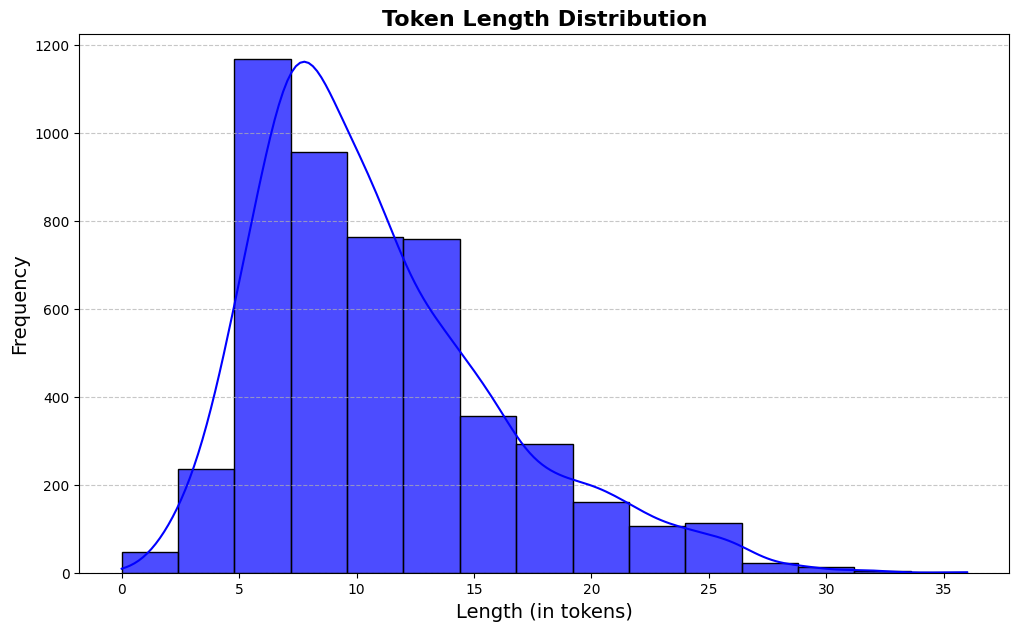

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcola la lunghezza dei token per ogni riga nella colonna 'tokens_no_stop'
token_lengths = df['tokens_no_stop'].apply(len)

# Statistiche sulla distribuzione delle lunghezze
max_length = token_lengths.max()
min_length = token_lengths.min()
avg_length = token_lengths.mean()

# Stampa delle statistiche
print(f'Lunghezza massima: {max_length}')
print(f'Lunghezza media: {avg_length:.2f}')

# Istogramma con distribuzione continua
plt.figure(figsize=(12, 7))
sns.histplot(token_lengths, bins=15, kde=True, color='blue', edgecolor='black', alpha=0.7)
plt.title('Token Length Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Length (in tokens)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Using model: bert-base-uncased
Creating balanced dataset...
Initializing tokenizer for bert-base-uncased...
Initializing model for bert-base-uncased...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training on cuda...

Epoch 1/2
Average training loss: 0.6841
Validation loss: 0.4150

Epoch 2/2
Average training loss: 0.2813
Validation loss: 0.3800


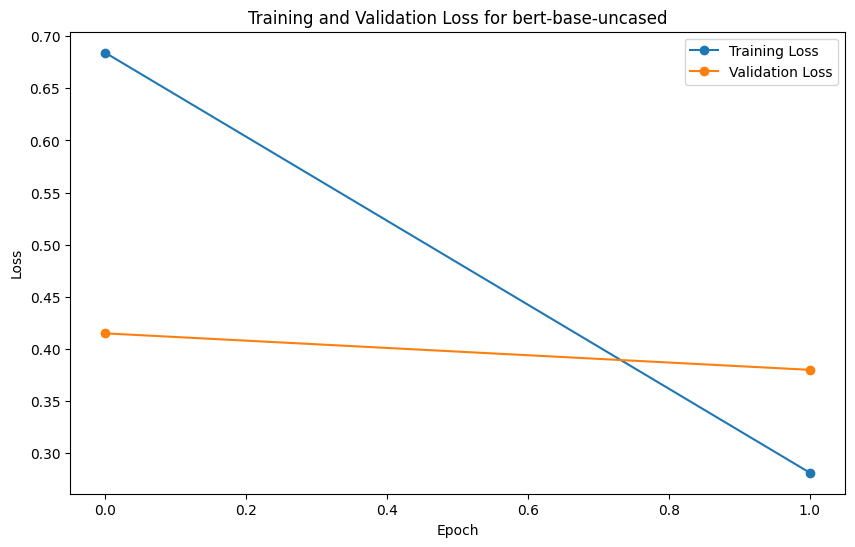


Evaluating...
Test Accuracy: 0.8710

Classification Report:
              precision    recall  f1-score   support

    Negative       0.78      0.99      0.87       333
     Neutral       0.92      0.78      0.84       333
    Positive       0.95      0.85      0.90       334

    accuracy                           0.87      1000
   macro avg       0.88      0.87      0.87      1000
weighted avg       0.88      0.87      0.87      1000


Confusion Matrix:


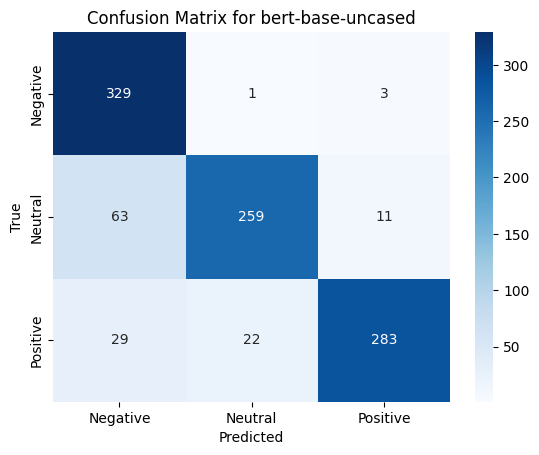


Using model: roberta-base
Creating balanced dataset...
Initializing tokenizer for roberta-base...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Initializing model for roberta-base...


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training on cuda...

Epoch 1/2
Average training loss: 0.5673
Validation loss: 0.4181

Epoch 2/2
Average training loss: 0.2953
Validation loss: 0.2781


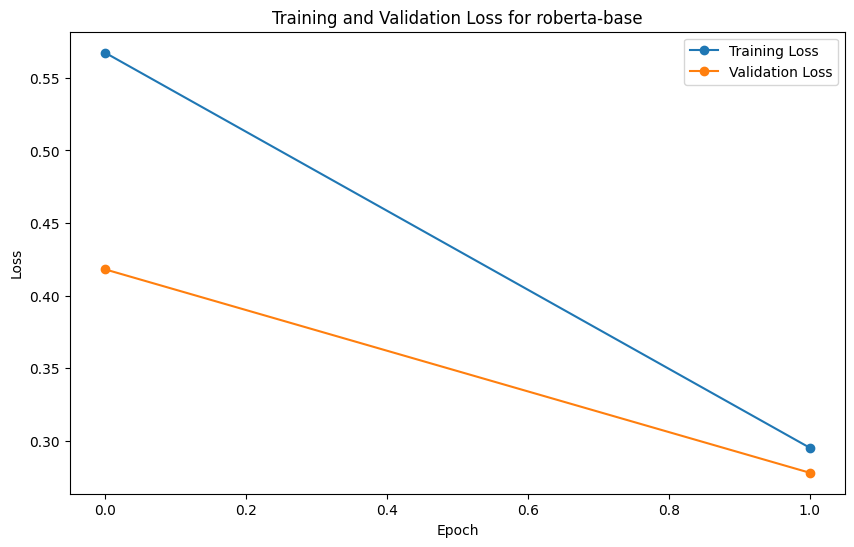


Evaluating...
Test Accuracy: 0.9040

Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.99      0.90       333
     Neutral       0.94      0.78      0.85       333
    Positive       0.97      0.94      0.95       334

    accuracy                           0.90      1000
   macro avg       0.91      0.90      0.90      1000
weighted avg       0.91      0.90      0.90      1000


Confusion Matrix:


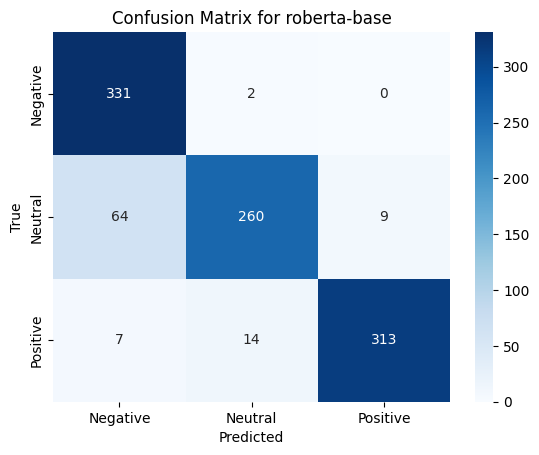


Using model: distilbert-base-uncased
Creating balanced dataset...
Initializing tokenizer for distilbert-base-uncased...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Initializing model for distilbert-base-uncased...


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training on cuda...

Epoch 1/2
Average training loss: 0.5950
Validation loss: 0.3856

Epoch 2/2
Average training loss: 0.2518
Validation loss: 0.3170


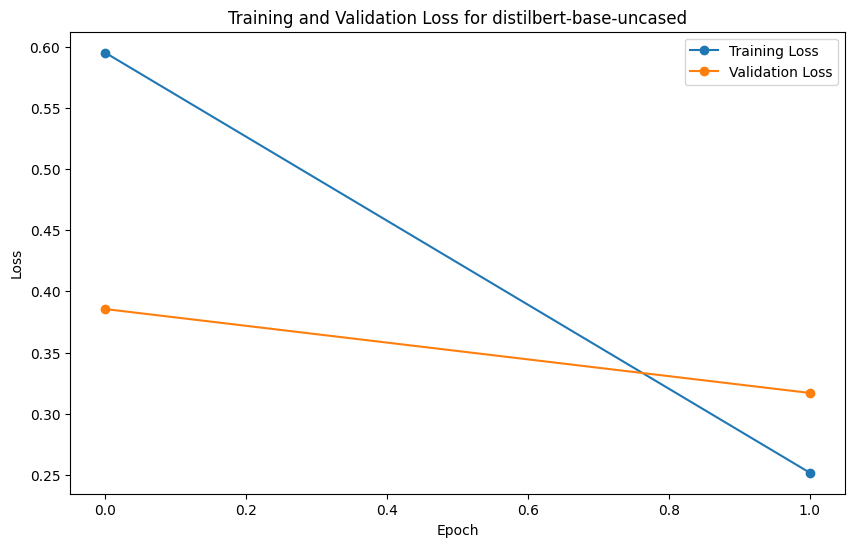


Evaluating...
Test Accuracy: 0.8900

Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.98      0.89       333
     Neutral       0.94      0.76      0.84       333
    Positive       0.93      0.93      0.93       334

    accuracy                           0.89      1000
   macro avg       0.90      0.89      0.89      1000
weighted avg       0.90      0.89      0.89      1000


Confusion Matrix:


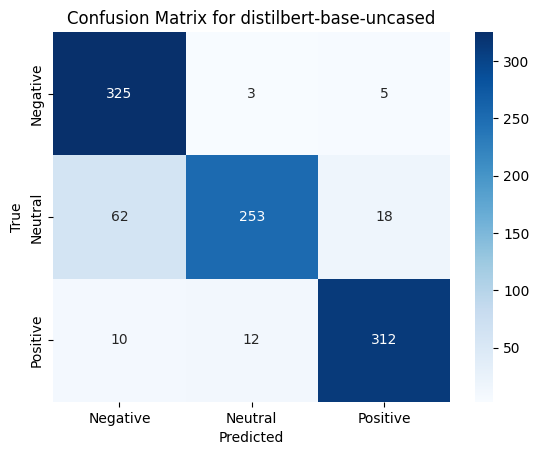


Using model: dmis-lab/biobert-base-cased
Creating balanced dataset...
Initializing tokenizer for dmis-lab/biobert-base-cased...


OSError: dmis-lab/biobert-base-cased is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [ ]:
# Import delle librerie necessarie
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, BertTokenizer, BertForSequenceClassification, DistilBertTokenizer, DistilBertForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Creazione dataset bilanciato
def create_balanced_dataset(df, n_samples=5000):
    sentiment_map = {
        'negative': 0,
        'neutral': 1,
        'positive': 2
    }
    df['label'] = df['sentiment'].map(sentiment_map)
    samples_per_class = n_samples // 3
    balanced_dfs = []
    for label in range(3):
        class_df = df[df['label'] == label]
        if len(class_df) > samples_per_class:
            balanced_dfs.append(class_df.sample(n=samples_per_class, random_state=42))
        else:
            balanced_dfs.append(class_df.sample(n=samples_per_class, replace=True, random_state=42))
    return pd.concat(balanced_dfs).sample(frac=1, random_state=42)

# Dataset personalizzato
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Funzione generica per addestramento del modello
def train_sentiment_model(df, model_name, tokenizer_class, model_class, test_size=0.2, num_epochs=2, batch_size=16, learning_rate=2e-5):
    print(f"\nUsing model: {model_name}")
    print("Creating balanced dataset...")
    balanced_df = create_balanced_dataset(df, n_samples=5000)
    train_df, test_df = train_test_split(balanced_df, test_size=test_size, random_state=42, stratify=balanced_df['label'])
    train_texts = train_df['text'].tolist()
    train_labels = train_df['label'].tolist()
    test_texts = test_df['text'].tolist()
    test_labels = test_df['label'].tolist()
    print(f"Initializing tokenizer for {model_name}...")
    tokenizer = tokenizer_class.from_pretrained(model_name)
    train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
    test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    print(f"Initializing model for {model_name}...")
    model = model_class.from_pretrained(model_name, num_labels=3)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # Per tracciare le perdite durante il training
    training_losses = []
    validation_losses = []

    print(f"Training on {device}...")
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        avg_train_loss = total_loss / len(train_loader)
        training_losses.append(avg_train_loss)

        # Calcolo della validation loss
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                val_loss += outputs.loss.item()
        avg_val_loss = val_loss / len(test_loader)
        validation_losses.append(avg_val_loss)

        print(f"Average training loss: {avg_train_loss:.4f}")
        print(f"Validation loss: {avg_val_loss:.4f}")

    # Grafico delle perdite
    plt.figure(figsize=(10, 6))
    plt.plot(training_losses, label='Training Loss', marker='o')
    plt.plot(validation_losses, label='Validation Loss', marker='o')
    plt.title(f'Training and Validation Loss for {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Valutazione finale
    print("\nEvaluating...")
    test_preds, test_true = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            test_preds.extend(preds)
            test_true.extend(labels.numpy())
    accuracy = accuracy_score(test_true, test_preds)
    print(f"Test Accuracy: {accuracy:.4f}")
    print('\nClassification Report:')
    print(classification_report(test_true, test_preds, target_names=['Negative', 'Neutral', 'Positive']))
    print("\nConfusion Matrix:")
    cm = confusion_matrix(test_true, test_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    return model, tokenizer, test_preds, test_true

# Funzione per eseguire un modello specifico
def run_model(df, model_name, tokenizer_class, model_class):
    model, tokenizer, test_preds, test_true = train_sentiment_model(df, model_name, tokenizer_class, model_class)
    return model, tokenizer, test_preds, test_true

# Specifica i modelli che vuoi utilizzare
MODELS = [
    ("bert-base-uncased", BertTokenizer, BertForSequenceClassification),
    ("roberta-base", RobertaTokenizer, RobertaForSequenceClassification),
    ("distilbert-base-uncased", DistilBertTokenizer, DistilBertForSequenceClassification),
    ("dmis-lab/biobert-base-cased", AutoTokenizer, AutoModelForSequenceClassification),
]

# Main
if __name__ == "__main__":
    # Assumendo che `df` sia il tuo dataframe di input
    for model_name, tokenizer_class, model_class in MODELS:
        model, tokenizer, test_preds, test_true = run_model(df, model_name, tokenizer_class, model_class)